Deep Learning School 2022. Шкарбаненко Михаил. Telegram @IInfiniteTsukuyomi

# Часть 1. Загрузка данных и сетап необходимых модулей.

Импорт небоходимых библиотек.

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from PIL import Image
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm.notebook import tqdm
import time

from matplotlib import pyplot as plt
%matplotlib inline

Загрузка трейн и тест датасетов в колаб.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!ls /content/gdrive/

MyDrive


In [4]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 21 19:30 /content/gdrive/MyDrive/journey-springfield.zip


In [5]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [6]:
!ls -1

characters_illustration.png
gdrive
label_encoder.pkl
sample_data
sample_submission.csv
testset
train


In [7]:
!ls train
!ls testset

simpsons_dataset
testset


In [8]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [9]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


Загрузка и предобработка данных. Аугментация + Ресайз + Скейл.

In [10]:
torch.cuda.is_available()

True

In [11]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [12]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == "train":    
            transform = transforms.Compose([
                                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                ])                 
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),   
                        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                    ])                     
        x = self.load_sample(self.files[index])
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
train_val_dataset = SimpsonsDataset(train_val_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode='test')

Посмотрим на персонажей из валидационного датасета.

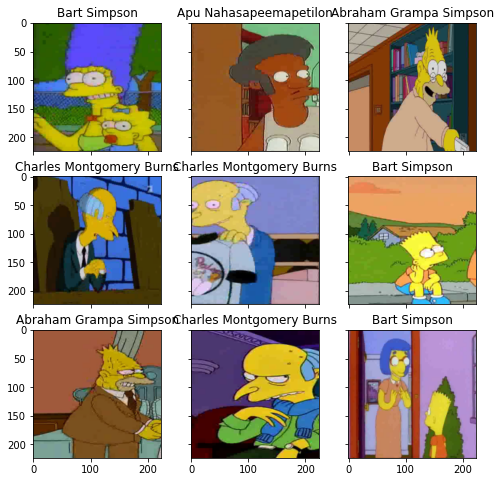

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Часть 2. Построение модели.

На семинарах и в бейзлайн ноутбуке прямо сказано - собственной нейросетью большой скор получить скорее всего не удастся. Поэтому сразу буду использовать Transfer Learning.

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    model.train(True)
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    if scheduler is not None:
        scheduler.step()
            
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_files, val_files, model, epochs, batch_size, scheduler, opt, criterion):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if val_acc > best_acc:  
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
            
    return model, history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
Model = models.resnet18(pretrained=True)
for name, p in Model.named_parameters():
    print("param name:", name, "requires_grad:", p.requires_grad)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


param name: conv1.weight requires_grad: True
param name: bn1.weight requires_grad: True
param name: bn1.bias requires_grad: True
param name: layer1.0.conv1.weight requires_grad: True
param name: layer1.0.bn1.weight requires_grad: True
param name: layer1.0.bn1.bias requires_grad: True
param name: layer1.0.conv2.weight requires_grad: True
param name: layer1.0.bn2.weight requires_grad: True
param name: layer1.0.bn2.bias requires_grad: True
param name: layer1.1.conv1.weight requires_grad: True
param name: layer1.1.bn1.weight requires_grad: True
param name: layer1.1.bn1.bias requires_grad: True
param name: layer1.1.conv2.weight requires_grad: True
param name: layer1.1.bn2.weight requires_grad: True
param name: layer1.1.bn2.bias requires_grad: True
param name: layer2.0.conv1.weight requires_grad: True
param name: layer2.0.bn1.weight requires_grad: True
param name: layer2.0.bn1.bias requires_grad: True
param name: layer2.0.conv2.weight requires_grad: True
param name: layer2.0.bn2.weight requi

Буду фитить последний сверточный и fc слои. Остальные замораживаю.

In [22]:
Model = Model.cuda()

num_features = Model.fc.in_features
n_classes = len(np.unique(train_val_labels))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(Model.parameters())[-8:], lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Часть 3. Обучение модели.

In [23]:
model, history = train(train_dataset, val_dataset, Model, epochs=10, batch_size=64, scheduler=exp_lr_scheduler, opt=optimizer, criterion=loss_fn)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8485052408380594

Epoch 001 train_loss: 0.8485     val_loss 0.4974 train_acc 0.8092 val_acc 0.8668
loss 0.24333203069310907

Epoch 002 train_loss: 0.2433     val_loss 0.3677 train_acc 0.9359 val_acc 0.9033
loss 0.11688030483472256

Epoch 003 train_loss: 0.1169     val_loss 0.3873 train_acc 0.9667 val_acc 0.9008
loss 0.049435083741131494

Epoch 004 train_loss: 0.0494     val_loss 0.2883 train_acc 0.9878 val_acc 0.9291
loss 0.02875069429255185

Epoch 005 train_loss: 0.0288     val_loss 0.3009 train_acc 0.9927 val_acc 0.9274
loss 0.015655890506521913

Epoch 006 train_loss: 0.0157     val_loss 0.2994 train_acc 0.9971 val_acc 0.9310
loss 0.007953409045859693

Epoch 007 train_loss: 0.0080     val_loss 0.2792 train_acc 0.9990 val_acc 0.9339
loss 0.004303924294670446

Epoch 008 train_loss: 0.0043     val_loss 0.2850 train_acc 0.9992 val_acc 0.9324
loss 0.004863450096990016

Epoch 009 train_loss: 0.0049     val_loss 0.2856 train_acc 0.9995 val_acc 0.9331
loss 0.0026853950344638547

Epoch

# Часть 4. Оценка качества модели.

График ошибки на трейн и вал датасетах в зависимости от эпохи.

In [24]:
loss, acc, val_loss, val_acc = zip(*history)

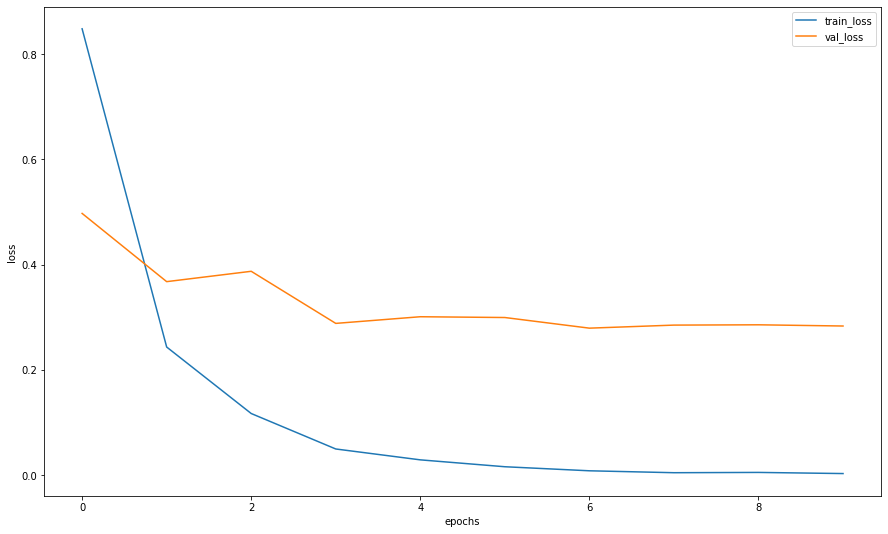

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Оценка f1-score на рандомном сэмпле картинок.

In [26]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [27]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(Model, ex_img.unsqueeze(0))

In [28]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
#imgs = [test_dataset[id].unsqueeze(0) for id in idxs]

probs_ims = predict(Model, imgs)

In [29]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [30]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [31]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.8000000000000002

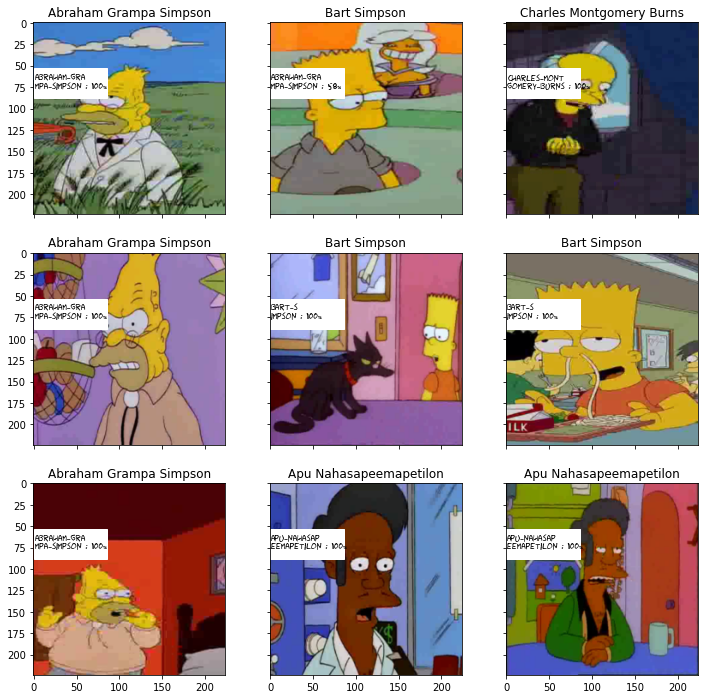

In [32]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(Model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Часть 5. Сабмит на Kaggle.

Переобучаю модель на всем датасете и делаю сабмит.

In [37]:
Model = models.resnet18(pretrained=True)
Model = Model.cuda()

num_features = Model.fc.in_features
n_classes = len(np.unique(train_val_labels))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(Model.parameters())[-8:], lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
model, history = train(train_val_dataset, val_dataset, Model, epochs=10, batch_size=64, scheduler=exp_lr_scheduler, opt=optimizer, criterion=loss_fn)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8358565569683294

Epoch 001 train_loss: 0.8359     val_loss 0.4433 train_acc 0.8089 val_acc 0.8865
loss 0.24280180631688217

Epoch 002 train_loss: 0.2428     val_loss 0.3604 train_acc 0.9353 val_acc 0.9056
loss 0.11917539702053169

Epoch 003 train_loss: 0.1192     val_loss 0.3482 train_acc 0.9684 val_acc 0.9104
loss 0.044897403007301905

Epoch 004 train_loss: 0.0449     val_loss 0.2945 train_acc 0.9889 val_acc 0.9276
loss 0.023295927453159438

Epoch 005 train_loss: 0.0233     val_loss 0.2984 train_acc 0.9952 val_acc 0.9322
loss 0.012324588782933478

Epoch 006 train_loss: 0.0123     val_loss 0.2949 train_acc 0.9976 val_acc 0.9318
loss 0.0077861761172258225

Epoch 007 train_loss: 0.0078     val_loss 0.2876 train_acc 0.9991 val_acc 0.9324
loss 0.005510996834534723

Epoch 008 train_loss: 0.0055     val_loss 0.2896 train_acc 0.9990 val_acc 0.9322
loss 0.004342038348849636

Epoch 009 train_loss: 0.0043     val_loss 0.2913 train_acc 0.9996 val_acc 0.9327
loss 0.0026566798868474903

Epo

In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(Model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [44]:
pd.read_csv('sample_submission.csv').head(1)

,Id,Expected
0,img0.jpg,bart_simpson


In [45]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('my_submit.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [46]:
my_submit.info

<bound method DataFrame.info of              Id                  Expected
0      img0.jpg              nelson_muntz
1      img1.jpg              bart_simpson
2     img10.jpg              ned_flanders
3    img100.jpg              chief_wiggum
4    img101.jpg    apu_nahasapeemapetilon
..          ...                       ...
986  img987.jpg              nelson_muntz
987  img988.jpg              ned_flanders
988  img989.jpg  charles_montgomery_burns
989   img99.jpg              chief_wiggum
990  img990.jpg          krusty_the_clown

[991 rows x 2 columns]>